In [9]:
!pip install sdv
!pip install ctgan

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
conn_eICU = sqlite3.connect('/content/drive/MyDrive/DS6050-main/eICU_gan/data/sqlite_eicu_v2_0_1.sqlite3')

In [16]:
'''sql = """SELECT * FROM patient"""
data_patients = pd.read_sql(sql, conn_eICU)
data_patients.head()'''

'sql = """SELECT * FROM patient"""\ndata_patients = pd.read_sql(sql, conn_eICU)\ndata_patients.head()'

In [17]:
df = pd.read_csv('/content/drive/MyDrive/DS6050-main/eICU_gan/data/patients_pasthist_forgan.csv')

In [18]:
df.head()

,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,...,head and neck,hypertension requiring treatment,hypothyroidism,insulin dependent diabetes,medication dependent,neuromuscular disease,primary site,renal insufficiency - creatinine 2-3,restrictive pulmonary disease,s/p AVR
0,Female,87.0,Caucasian,59,91,NaN,157.5,23:36:00,-2258,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Female,87.0,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,-8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Male,76.0,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,-1,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Female,34.0,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,-23,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Male,61.0,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,-10,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ages_unit_np = np.load("/content/drive/MyDrive/DS6050-main/eICU_gan/data/eICU_age_unittype.npy", allow_pickle=True)
print('length: ', len(ages_unit_np))
print(ages_unit_np[0:5])

ages_np = np.asarray(ages_unit_np[:,0].flatten().tolist()).flatten()
print('ages length: ', len(ages_np))
#print(ages_np[0:5])

unit_np = np.asarray(ages_unit_np[:,1].flatten().tolist()).flatten()
print('unit length: ', len(unit_np))
#print(ethnicity_np[0:5])

df_ages = pd.DataFrame(zip(ages_np, unit_np), columns=['age','unit'])
print(df_ages.shape)
print(df_ages.groupby('unit').count())

# create data set without 90 or greater since that was a category flattened
print("==" * 30)
print("FILTERED:")
df_ages_filtered = df_ages.query("age < 90")
df_ages_filtered['unit_code'] = df_ages_filtered['unit'].astype('category').cat.codes
print(df_ages_filtered.groupby('unit').count())


mean_age_filtered = df_ages_filtered.age.mean()
std_age_filtered =  df_ages_filtered.age.std()
min_age_filtered =  df_ages_filtered.age.min()
max_age_filtered =  df_ages_filtered.age.max()

print("mean age: ", mean_age_filtered)
print("std age: ", np.round(std_age_filtered,3))
print("min age: ", min_age_filtered)
print("max age: ", max_age_filtered)

scaled_ages_filtered = [(x - min_age_filtered)/(max_age_filtered - min_age_filtered) for x in df_ages_filtered['age']]
all_ages = np.reshape(scaled_ages_filtered, (-1, 1))

all_labels = keras.utils.to_categorical(df_ages_filtered['unit_code'], 3)


print(scaled_ages_filtered[0:5])
print(np.array(all_labels[0:5]))
print(f"Shape of ages: {all_ages.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)
#list(dataset.as_numpy_iterator())
#for element in dataset:
#    print(element)


length:  250
[[(59,) ('CTICU',)]
 [(55,) ('CTICU',)]
 [(72,) ('Cardiac ICU',)]
 [(49,) ('CTICU',)]
 [(49,) ('CTICU',)]]
ages length:  250
unit length:  250
(250, 2)
             age
unit            
CSICU         65
CTICU         52
Cardiac ICU  133
FILTERED:
             age  unit_code
unit                       
CSICU         65         65
CTICU         52         52
Cardiac ICU  133        133
mean age:  62.472
std age:  14.503
min age:  21
max age:  89
[0.5588235294117647, 0.5, 0.75, 0.4117647058823529, 0.4117647058823529]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
Shape of ages: (250, 1)
Shape of labels: (250, 3)


In [6]:
print(os.getcwd())

/content


In [7]:
ages_unit_np[:5]

array([[(59,), ('CTICU',)],
       [(55,), ('CTICU',)],
       [(72,), ('Cardiac ICU',)],
       [(49,), ('CTICU',)],
       [(49,), ('CTICU',)]], dtype=object)

In [11]:
from ctgan import CTGANSynthesizer

In [22]:
df[['age', 'ethnicity']]

,age,ethnicity
0,87.0,Caucasian
1,87.0,Caucasian
2,76.0,Caucasian
3,34.0,Caucasian
4,61.0,Caucasian
5,55.0,Caucasian
6,55.0,Caucasian
7,60.0,Hispanic
8,28.0,Caucasian
9,34.0,Caucasian


In [25]:
from sdv.tabular import CTGAN

In [77]:
#CTGAN?

In [78]:
ctgan = CTGAN(verbose=True, epochs = 2000, batch_size = 40)
ctgan.fit(df[['age', 'ethnicity']])

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/ctgan/data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()


Epoch 1, Loss G:  1.3217,Loss D: -0.1488
Epoch 2, Loss G:  1.2618,Loss D:  0.1214
Epoch 3, Loss G:  0.7945,Loss D:  0.4121
Epoch 4, Loss G:  0.5565,Loss D: -0.1443
Epoch 5, Loss G:  0.5805,Loss D: -0.2554
Epoch 6, Loss G:  0.4233,Loss D:  0.1704
Epoch 7, Loss G:  0.0645,Loss D:  0.0640
Epoch 8, Loss G: -0.0416,Loss D:  0.1100
Epoch 9, Loss G: -0.2130,Loss D:  0.1471
Epoch 10, Loss G: -0.1679,Loss D: -0.1846
Epoch 11, Loss G: -0.1908,Loss D: -0.0219
Epoch 12, Loss G: -0.1152,Loss D: -0.4138
Epoch 13, Loss G: -0.3104,Loss D: -0.0511
Epoch 14, Loss G: -0.3086,Loss D:  0.2449
Epoch 15, Loss G: -0.6338,Loss D:  0.2656
Epoch 16, Loss G:  0.0718,Loss D: -0.2940
Epoch 17, Loss G: -0.2533,Loss D:  0.1903
Epoch 18, Loss G: -0.2103,Loss D: -0.5873
Epoch 19, Loss G: -0.5276,Loss D:  0.1664
Epoch 20, Loss G: -0.6025,Loss D:  0.3667
Epoch 21, Loss G: -0.4369,Loss D: -0.4748
Epoch 22, Loss G: -0.4654,Loss D: -0.1815
Epoch 23, Loss G: -0.3553,Loss D:  0.3235
Epoch 24, Loss G: -0.4289,Loss D: -0.1015
E

In [79]:
samples = ctgan.sample(df.shape[0])

In [80]:
samples['data'] = 'GAN'

In [81]:
df['data'] = 'Real'

In [82]:
both = pd.concat([samples, df[['age', 'ethnicity', 'data']]])

In [83]:
caucasian = both[both['ethnicity'] == 'Caucasian'].reset_index().drop('index', axis = 1)

In [84]:
african_american = both[both['ethnicity'] == 'African American'].reset_index().drop('index', axis = 1)

In [85]:
native_american = both[both['ethnicity'] == 'Native American'].reset_index().drop('index', axis = 1)

In [86]:
other = both[both['ethnicity'] == 'Other/Unknown'].reset_index().drop('index', axis = 1)

<function matplotlib.pyplot.show>

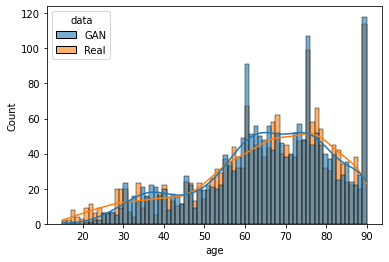

In [87]:
sns.histplot(data = caucasian, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show>

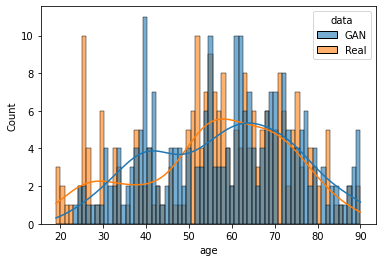

In [88]:
sns.histplot(data = african_american, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show>

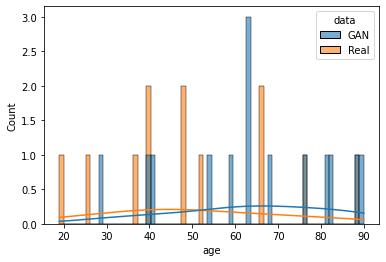

In [89]:
sns.histplot(data = native_american, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show>

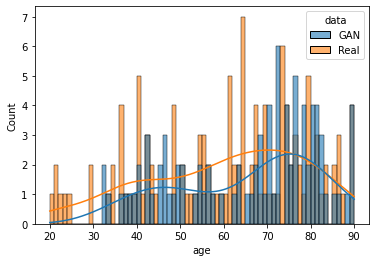

In [90]:
sns.histplot(data = other, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show